In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils.mlflow_query import MlflowHelper

In [2]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), local_mlflow_dir_prefix='../../mlruns/')
mlflow_helper.query_runs(pkl_file=Path("mlflow_run_df.pkl"), filter_string= "tags.test = '1'")

Querying data per run...: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


In [3]:
def plot_metrics_over_epochs(metric_df, metric_names, 
    column_feature_name='data_tags_model_type', 
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    style_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, {col_name}",
):
    for metric_name in metric_names:
        g = sns.relplot(
            data=metric_df, x="epoch", y=metric_name,
            col=column_feature_name, row=row_feature_name, 
            hue=hue_feature_name, style=style_feature_name, 
            units='info_run_id', estimator=None,
            kind="line", facet_kws={'sharey':False},
        )
        g.set_titles(titles)
        g.savefig("epochs_{}.png".format(metric_name))

def plot_best_metric_strip(metric_df, metric_names, feature_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic',], #'causal_score'],
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    column_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, Trainable: {col_name}",
):
    grouped_df = metric_df.groupby(feature_names, as_index=False).agg({
        metric_name:max for metric_name in metric_names
    })
    for metric_name in metric_names:
        g = sns.catplot(
            data=grouped_df, y=metric_name, 
            x=x_feature_name, order=x_order, row=row_feature_name, 
            hue=hue_feature_name, col=column_feature_name,
            kind="strip", sharey='row',
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)

        g.savefig("strip_{}.png".format(metric_name))

def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic',], #'causal_score'],
    row_feature_name='data_tags_sequence_type',
    hue_feature_name='data_params_ModelConfighidden_embedding_initializer',
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    titles="{row_name}, Trainable: {col_name}",
    palette=None,
    dodge=True,
    col_order=None,
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge,
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        g.savefig("bar_{}.png".format(metric_name))


Querying metrics for runs: 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


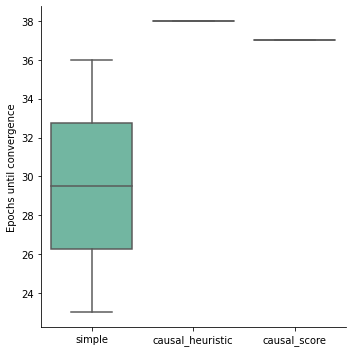

In [4]:
df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True)
df = mlflow_helper.load_best_metrics_for_ids(set(df["info_run_id"]))
g = sns.catplot(
    data=df, 
    x="data_tags_model_type",
    y='epoch', 
    order=["simple", "causal_heuristic", "causal_score"],
    #col="data_params_ModelConfigbase_hidden_embeddings_trainable",
    #col_order=["False", "True"],
    kind="box", 
    palette='Set2', 
    #color="#19b39c",
    #dodge=False,
).set_axis_labels('', "Epochs until convergence")#.set_titles("Embeddings trainable: {col_name}")
plt.tight_layout()
# plt.savefig("huawei_epochs_nontrainable.png", dpi=100)
plt.show()

Querying metrics for runs: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


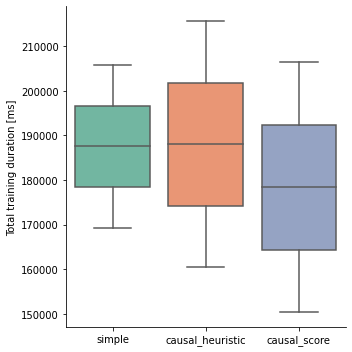

In [5]:
df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True)
df = mlflow_helper.load_training_times_for_ids(set(df["info_run_id"]))
g = sns.catplot(
    data=df
    , x="data_tags_model_type",
    y='total_duration', 
    order=["simple", "causal_heuristic", "causal_score"],
    #col_order=["False", "True"],
    kind="box", 
    palette='Set2', 
    #color="#19b39c",
    #dodge=False,
).set_axis_labels('', "Total training duration [ms]")#.set_titles("Embeddings trainable: {col_name}")
plt.tight_layout()
plt.savefig("huawei_total_duration_nontrainable.png", dpi=100)
plt.show()

In [6]:
df["avg_per_epoch_conv"] = df["avg_per_epoch"] / (1000)
df.groupby(by="data_tags_model_type")["avg_per_epoch_conv"].describe()

,count,mean,std,min,25%,50%,75%,max
data_tags_model_type,,,,,,,,
causal_heuristic,2.0,4.700900,0.975913,4.010825,4.355862,4.700900,5.045937,5.390975
causal_score,2.0,4.460175,0.992035,3.758700,4.109438,4.460175,4.810912,5.161650
simple,2.0,5.394188,0.351167,5.145875,5.270031,5.394188,5.518344,5.642500


Querying metrics for runs: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


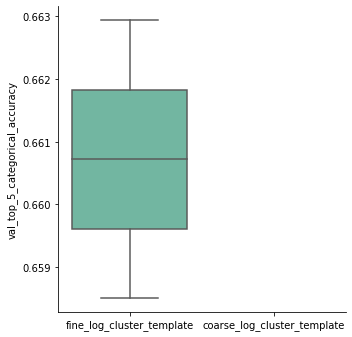

In [7]:
df = mlflow_helper.huawei_run_df(
    include_noise=False, 
    include_refinements=False, 
    risk_prediction=False,
    include_drain_hierarchy=True,
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template"])

df = mlflow_helper.load_best_metrics_for_ids(set(df["info_run_id"]))
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "log_cluster_template": "fine_log_cluster_template",
}.get(x, x))
df["baseline"] = df["data_tags_model_type"] == "simple"

g = sns.catplot(
    data=df[
        df["data_tags_model_type"].apply(lambda x: x == "simple")
    ], x="data_params_SequenceConfigx_sequence_column_name", y='val_top_5_categorical_accuracy_history_best', 
    order=["fine_log_cluster_template", "coarse_log_cluster_template"],
    kind="box", palette='Set2',
    dodge=False,
).set_axis_labels('', "val_top_5_categorical_accuracy")
plt.show()

In [8]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


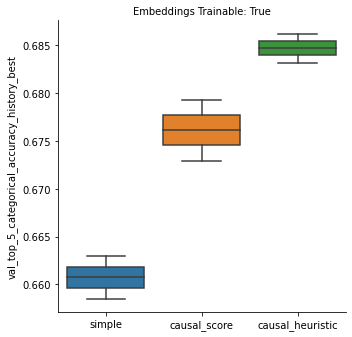

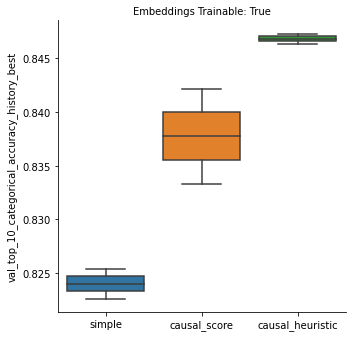

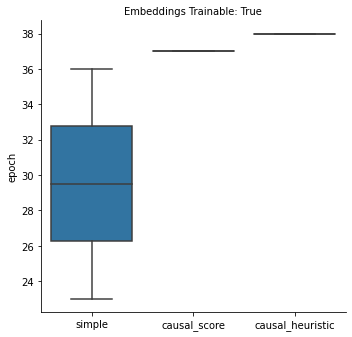

In [10]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best', 'val_top_10_categorical_accuracy_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    row_feature_name=None,
    x_order=["simple", "causal_score", "causal_heuristic"],
    titles="Embeddings Trainable: {col_name}")
plt.show()

In [15]:
huawei_df = mlflow_helper.huawei_run_df(
    include_noise=False, include_refinements=False, risk_prediction=False, include_drain_hierarchy=True,
    valid_x_columns=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template_90"])
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


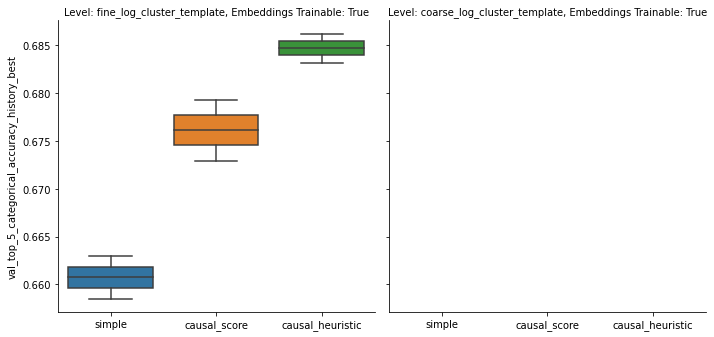

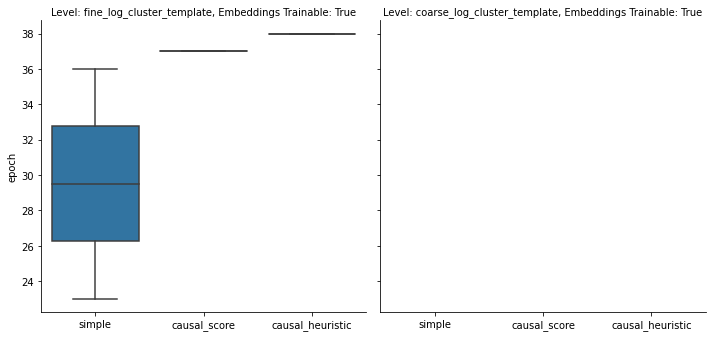

In [13]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best', 'epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_SequenceConfigx_sequence_column_name',
    row_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    col_order=["fine_log_cluster_template", "coarse_log_cluster_template"],
    x_order=["simple", "causal_score", "causal_heuristic"],
    titles="Level: {col_name}, Embeddings Trainable: {row_name}")
plt.show()

In [16]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_metric_history_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


In [19]:
huawei_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, risk_prediction=False)
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))

Querying metrics for runs: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


In [20]:
prediction_df = pd.read_csv(mlflow_helper.local_mlflow_dir + str(huawei_df["info_run_id"].iloc[0]) + "/artifacts/prediction_output.csv")
prediction_df

,input,output,predictions
0,{0: ['fine_log_cluster_template#get v3 domains...,"['Hostname#wally113', 'http_status#300.0', 'ht...","{'Hostname#wally122': 0.00031086916, 'python_m..."
1,{0: ['fine_log_cluster_template#get http 11 30...,"['Hostname#wally113', 'http_status#200.0', 'ht...","{'Hostname#wally122': 0.0002119352, 'python_mo..."
2,{0: ['fine_log_cluster_template#could not find...,"['Hostname#wally113', 'http_status#200.0', 'ht...","{'Hostname#wally122': 0.00041081407, 'python_m..."
3,{0: ['fine_log_cluster_template#could not find...,"['http_method#post', 'Hostname#wally113', 'htt...","{'Hostname#wally122': 0.00036329904, 'python_m..."
4,{0: ['fine_log_cluster_template#get http 11 30...,"['http_method#post', 'Hostname#wally113', 'htt...","{'Hostname#wally122': 0.0003647095, 'python_mo..."
...,...,...,...
994,{0: ['fine_log_cluster_template#get v20 ports ...,"['Hostname#wally113', 'programname#neutron-ser...","{'Hostname#wally122': 0.00015340344, 'python_m..."
995,{0: ['fine_log_cluster_template#get v20 ports ...,"['Hostname#wally113', 'programname#neutron-ser...","{'Hostname#wally122': 0.00019768394, 'python_m..."
996,{0: ['fine_log_cluster_template#get v20 ports ...,"['Hostname#wally113', 'programname#neutron-ser...","{'Hostname#wally122': 0.00030921344, 'python_m..."
997,{0: ['fine_log_cluster_template#added segment ...,"['Hostname#wally113', 'programname#neutron-ser...","{'Hostname#wally122': 0.00055720814, 'python_m..."


In [21]:
prediction_df['input'].apply(lambda x: 1 if "exception" in x.lower() else 0).sum()

0

In [29]:
huawei_df[['epoch', 'data_tags_model_type']]

,epoch,data_tags_model_type
0,37,causal_score
1,23,simple
2,38,causal_heuristic
3,38,causal_heuristic
4,36,simple
5,37,causal_score


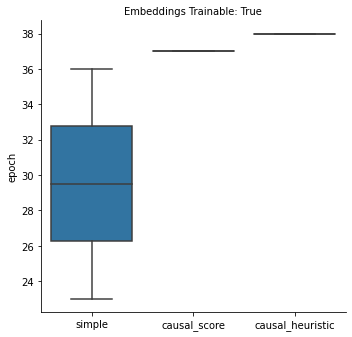

In [23]:
plot_best_metric_bar(huawei_df, ['epoch'], 
    hue_feature_name=None, 
    col_feature_name='data_params_ModelConfigbase_hidden_embeddings_trainable',
    row_feature_name=None,
    x_order=["simple", "causal_score", "causal_heuristic"],
    titles="Embeddings Trainable: {col_name}")
plt.show()

# NOISE

In [ ]:
mimic_noise_df = mlflow_helper.mimic_run_df(include_noise=True)
mimic_noise_df = mlflow_helper.load_best_metrics_for_ids(set(mimic_noise_df["info_run_id"]))
mimic_noise_df['data_tags_noise_type'] = mimic_noise_df['data_tags_noise_type'].fillna('').astype(str).apply(lambda x: x + '_threshold0.0' if len(str(x)) <= len('added0.0_removed0.1') and len(x) > 0 else x)
mimic_noise_df['data_tags_noise_type'] = mimic_noise_df['data_tags_noise_type'].apply(lambda x: 'no_noise' if len(x) == 0  or x == 'nan' else x)

In [ ]:
mimic_noise_df = mimic_noise_df[mimic_noise_df['data_tags_model_type'].apply(lambda x: x in ['hierarchy', 'gram', 'causal', 'text'])].copy().reset_index(drop=True)
mimic_noise_df = mimic_noise_df[mimic_noise_df['data_tags_noise_type'].str.endswith('_threshold0.0') | mimic_noise_df['data_tags_noise_type'].str.endswith('no_noise')].copy().reset_index(drop=True)
mimic_noise_df['noise'] = mimic_noise_df['data_tags_noise_type'].apply(
    lambda x: float(x[len('added'):len('added0.0')]) - float(x[len('added0.0_removed'):len('added0.0_removed0.0')]) if not (x == 'no_noise') else 0.0
)
mimic_noise_df['Knowledge Graph'] = mimic_noise_df['noise'].apply(lambda x: 'Original' if x == 0.0 else 'Noisy')
mimic_noise_df["Domain Knowledge"] = mimic_noise_df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
}.get(x, x))

g = sns.catplot(
    data=mimic_noise_df[
        mimic_noise_df["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], x="noise", y='val_top_20_categorical_accuracy_history_best', 
    col="Domain Knowledge",
    col_order=["hierarchy", "causal", "text"],
    kind="box", palette='Set2',
    hue="Knowledge Graph", dodge=False,
    hue_order=["Noisy", "Original"],
).set_axis_labels('Degree of Noise', "val_top_20_categorical_accuracy").set_titles("Domain Knowledge: {col_name}")

#plt.tight_layout()
plt.savefig("noise.png", dpi=100, bbox_inches="tight")
plt.show()